In [ ]:
# Import necessary libraries
import os
import json
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import zipfile
import urllib.request
from PIL import Image
import random
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Adding test dataset
zip_path = "./TestDataSet.zip"
extract_path = "./data"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset extracted.")
else:
    print("Dataset already extracted.")

Dataset extracted.


In [4]:
# Load class label mapping
labels_json_path = os.path.join(extract_path, "labels_list.json")
with open(labels_json_path) as f:
    raw_labels = json.load(f)

print(f"Loaded {len(raw_labels)} labels.")
print(raw_labels[:5])

Loaded 100 labels.
['401: accordion', '402: acoustic guitar', '403: aircraft carrier', '404: airliner', '405: airship']


In [ ]:
index_file = "imagenet_class_index.json"
if not os.path.exists(index_file):
    # Download ImageNet class index 
    url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
    print("Downloading ImageNet class index...")
    # Download the json file mapping ImageNet class indices to human-readable labels
    urllib.request.urlretrieve("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json", index_file)

with open(index_file) as f:
    class_idx = json.load(f)

# Create mapping from WordNet ID to index
wnid_to_idx = {v[0]: int(k) for k, v in class_idx.items()}

# Build folder_to_idx using folder names
folder_to_idx = {}
for folder in sorted(os.listdir(extract_path)):
    folder_path = os.path.join(extract_path, folder)
    if os.path.isdir(folder_path) and folder in wnid_to_idx:
        folder_to_idx[folder] = wnid_to_idx[folder]

In [6]:
print(folder_to_idx)

{'n02672831': 401, 'n02676566': 402, 'n02687172': 403, 'n02690373': 404, 'n02692877': 405, 'n02699494': 406, 'n02701002': 407, 'n02704792': 408, 'n02708093': 409, 'n02727426': 410, 'n02730930': 411, 'n02747177': 412, 'n02749479': 413, 'n02769748': 414, 'n02776631': 415, 'n02777292': 416, 'n02782093': 417, 'n02783161': 418, 'n02786058': 419, 'n02787622': 420, 'n02788148': 421, 'n02790996': 422, 'n02791124': 423, 'n02791270': 424, 'n02793495': 425, 'n02794156': 426, 'n02795169': 427, 'n02797295': 428, 'n02799071': 429, 'n02802426': 430, 'n02804414': 431, 'n02804610': 432, 'n02807133': 433, 'n02808304': 434, 'n02808440': 435, 'n02814533': 436, 'n02814860': 437, 'n02815834': 438, 'n02817516': 439, 'n02823428': 440, 'n02823750': 441, 'n02825657': 442, 'n02834397': 443, 'n02835271': 444, 'n02837789': 445, 'n02840245': 446, 'n02841315': 447, 'n02843684': 448, 'n02859443': 449, 'n02860847': 450, 'n02865351': 451, 'n02869837': 452, 'n02870880': 453, 'n02871525': 454, 'n02877765': 455, 'n0287971

In [ ]:
# Resnet34 model
model = models.resnet34(weights="IMAGENET1K_V1").to(device)
model.eval()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 192MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Normalization values for ImageNet
mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]

# Define the transformations
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

In [9]:
dataset_path = extract_path

# Use ImageFolder loader
dataset = datasets.ImageFolder(root=dataset_path, transform=plain_transforms)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [ ]:
# Create a mapping from the custom dataset class indices to ImageNet indices
custom_class_to_imagenet_idx = {dataset.class_to_idx[k]: folder_to_idx[k] for k in dataset.class_to_idx}

In [ ]:
# Evaluate the model on clean data
top1_correct = 0
top5_correct = 0
total = 0

with torch.no_grad():
    for images, targets in tqdm(dataloader):
        images = images.to(device)
        targets = torch.tensor([custom_class_to_imagenet_idx[int(t)] for t in targets]).to(device)

        outputs = model(images)
        _, top5 = outputs.topk(5, dim=1)

        top1_correct += (top5[:, 0] == targets).sum().item()
        top5_correct += sum([targets[i] in top5[i] for i in range(len(targets))])
        total += targets.size(0)

100%|██████████| 16/16 [00:02<00:00,  5.92it/s]


In [12]:
print(f"Top-1 Accuracy: {top1_correct / total * 100:.2f}%")
print(f"Top-5 Accuracy: {top5_correct / total * 100:.2f}%")

Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%


### Task 2: Pixel-wise attacks

In [ ]:
# FGSM attack
def fgsm_attack(image, epsilon, data_grad):
    """
    This function applies the FGSM attack to the input image.
    :param image: The input image
    :param epsilon: The perturbation magnitude
    :param data_grad: The gradient of the loss with respect to the input image
    :return: The perturbed image
    """
    # Collect the elements of the gradient that have the same sign as the perturbation
    perturbed_image = image + epsilon * data_grad.sign()
    
    # Ensure the perturbed image is within valid range [0, 1]
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    return perturbed_image

In [21]:
adv_output_dir = "./AdversarialTestSet1"
os.makedirs(adv_output_dir, exist_ok=True)

In [ ]:
# Hyperparameter (epsilon) for FGSM
epsilon = 0.02
top1_adv, top5_adv, total_adv = 0, 0, 0
adv_images = []
original_images = []

In [23]:
# Use unnormalized images for saving/visualizing
inv_normalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(mean_norms, std_norms)],
    std=[1/s for s in std_norms]
)

In [ ]:
# Verify L infinity constraint
def verify_linf_constraint(original_tensor, adversarial_tensor, epsilon=0.02, tol=1e-6):
    diff = torch.abs(adversarial_tensor - original_tensor)
    max_diff = diff.max().item()
    return max_diff <= (epsilon + tol), max_diff

In [ ]:
max_deltas = []
for i, (images, targets) in enumerate(tqdm(dataloader)):
    images, targets = images.to(device), targets.to(device)
    images.requires_grad = True

    outputs = model(images)
    # Cross Entropy loss
    loss = torch.nn.functional.cross_entropy(outputs, torch.tensor([custom_class_to_imagenet_idx[int(t)] for t in targets]).to(device))
    model.zero_grad()
    loss.backward()

    data_grad = images.grad.data
    # Generate adversarial examples
    perturbed_data = fgsm_attack(images, epsilon, data_grad)

    # Save adversarial images for inspection
    for j in range(images.size(0)):
        orig_tensor = images[j].cpu()
        adv_tensor = perturbed_data[j].cpu()
        # Verify L infinity constraint
        satisfies_constraint, max_delta = verify_linf_constraint(orig_tensor, adv_tensor, epsilon)
        max_deltas.append(max_delta)

        # Unnormalize and save the images
        adv_img_unnorm = inv_normalize(perturbed_data[j].cpu()).clamp(0, 1).detach().numpy()
        adv_img_unnorm = np.transpose(adv_img_unnorm, (1, 2, 0))
        adv_img_unnorm = np.clip(adv_img_unnorm * 255, 0, 255).astype(np.uint8)
        img_pil = Image.fromarray(adv_img_unnorm)

        # Add label folder and filename
        label_folder = list(dataset.class_to_idx.keys())[targets[j].item()]
        fname = dataset.imgs[i * dataloader.batch_size + j][0].split("/")[-1]
        save_dir = os.path.join(adv_output_dir, label_folder)
        os.makedirs(save_dir, exist_ok=True)
        img_pil.save(os.path.join(save_dir, fname))

    # Evaluate adversarial
    outputs_adv = model(perturbed_data)
    _, top5_preds = outputs_adv.topk(5, dim=1)
    imagenet_targets = torch.tensor([custom_class_to_imagenet_idx[int(t)] for t in targets]).to(device)

    top1_adv += (top5_preds[:, 0] == imagenet_targets).sum().item()
    top5_adv += sum([imagenet_targets[b] in top5_preds[b] for b in range(len(imagenet_targets))])
    total_adv += len(targets)

100%|██████████| 16/16 [00:05<00:00,  2.87it/s]


In [26]:
print(f"Max delta (epsilon) across dataset: {max(max_deltas):.6f}")

Max delta (epsilon) across dataset: 0.020000


In [27]:
print("\n--- FGSM Attack Results ---")
print(f"Top-1 Accuracy after attack: {top1_adv / total_adv * 100:.2f}%")
print(f"Top-5 Accuracy after attack: {top5_adv / total_adv * 100:.2f}%")


--- FGSM Attack Results ---
Top-1 Accuracy after attack: 6.00%
Top-5 Accuracy after attack: 35.40%


In [28]:
with open("imagenet_class_index.json", "r") as f:
    idx_to_label_map = json.load(f)

def idx_to_name(idx):
    return idx_to_label_map[str(idx)][1]

def format_label(idx):
    return f"{idx}: {idx_to_name(idx)}"

In [ ]:
# Function to show adversarial examples with original, adversarial, and difference images
def show_adversarial_examples(dataset, inv_normalize, num_samples=5, attack_name="FGSM", attack_folder="AdversarialTestSet1", seed=None):
    if seed is not None:
        random.seed(seed)

    indices = list(range(len(dataset)))
    random.shuffle(indices)

    collected = []
    
    # Collect adversarial examples that are misclassified
    for idx in indices:
        orig_img_path, class_idx = dataset.imgs[idx]
        folder_name = os.path.basename(os.path.dirname(orig_img_path))
        fname = os.path.basename(orig_img_path)

        # Original image and prediction
        orig_img = Image.open(orig_img_path).convert('RGB')
        tensor_img = transforms.ToTensor()(orig_img).unsqueeze(0).to(device)
        norm_img = transforms.Normalize(mean=mean_norms, std=std_norms)(tensor_img)
        pred_orig = model(norm_img).argmax(dim=1).item()

        # Adversarial image and prediction
        adv_path = os.path.join(attack_folder, folder_name, fname)
        if not os.path.exists(adv_path):
            continue  # skip if adversarial image is missing

        adv_img = Image.open(adv_path).convert('RGB')
        tensor_adv = transforms.ToTensor()(adv_img).unsqueeze(0).to(device)
        norm_adv = transforms.Normalize(mean=mean_norms, std=std_norms)(tensor_adv)
        pred_adv = model(norm_adv).argmax(dim=1).item()

        true_idx = custom_class_to_imagenet_idx[dataset.class_to_idx[folder_name]]

        # If misclassified
        if pred_adv != true_idx:
            collected.append((orig_img, adv_img, true_idx, pred_orig, pred_adv))

        if len(collected) == num_samples:
            break

    # Plotting
    fig, axs = plt.subplots(num_samples, 3, figsize=(12, 3 * num_samples))
    fig.suptitle(f"{attack_name} Adversarial Examples", fontsize=16)

    for row, (orig_img, adv_img, true_idx, pred_orig, pred_adv) in enumerate(collected):
        axs[row, 0].imshow(orig_img)
        axs[row, 0].axis('off')
        axs[row, 0].set_title(f"Original\nTrue: {format_label(true_idx)}\nPred: {format_label(pred_orig)}")

        axs[row, 1].imshow(adv_img)
        axs[row, 1].axis('off')
        axs[row, 1].set_title(f"Adversarial\nTrue: {format_label(true_idx)}\nPred: {format_label(pred_adv)}")

        # Difference image
        diff = np.abs(np.array(adv_img).astype(np.float32) - np.array(orig_img).astype(np.float32))
        amplified = np.clip(diff * 5, 0, 255).astype(np.uint8)
        axs[row, 2].imshow(amplified)
        axs[row, 2].axis('off')
        axs[row, 2].set_title("Pixel Difference")

    plt.tight_layout()
    plt.show()

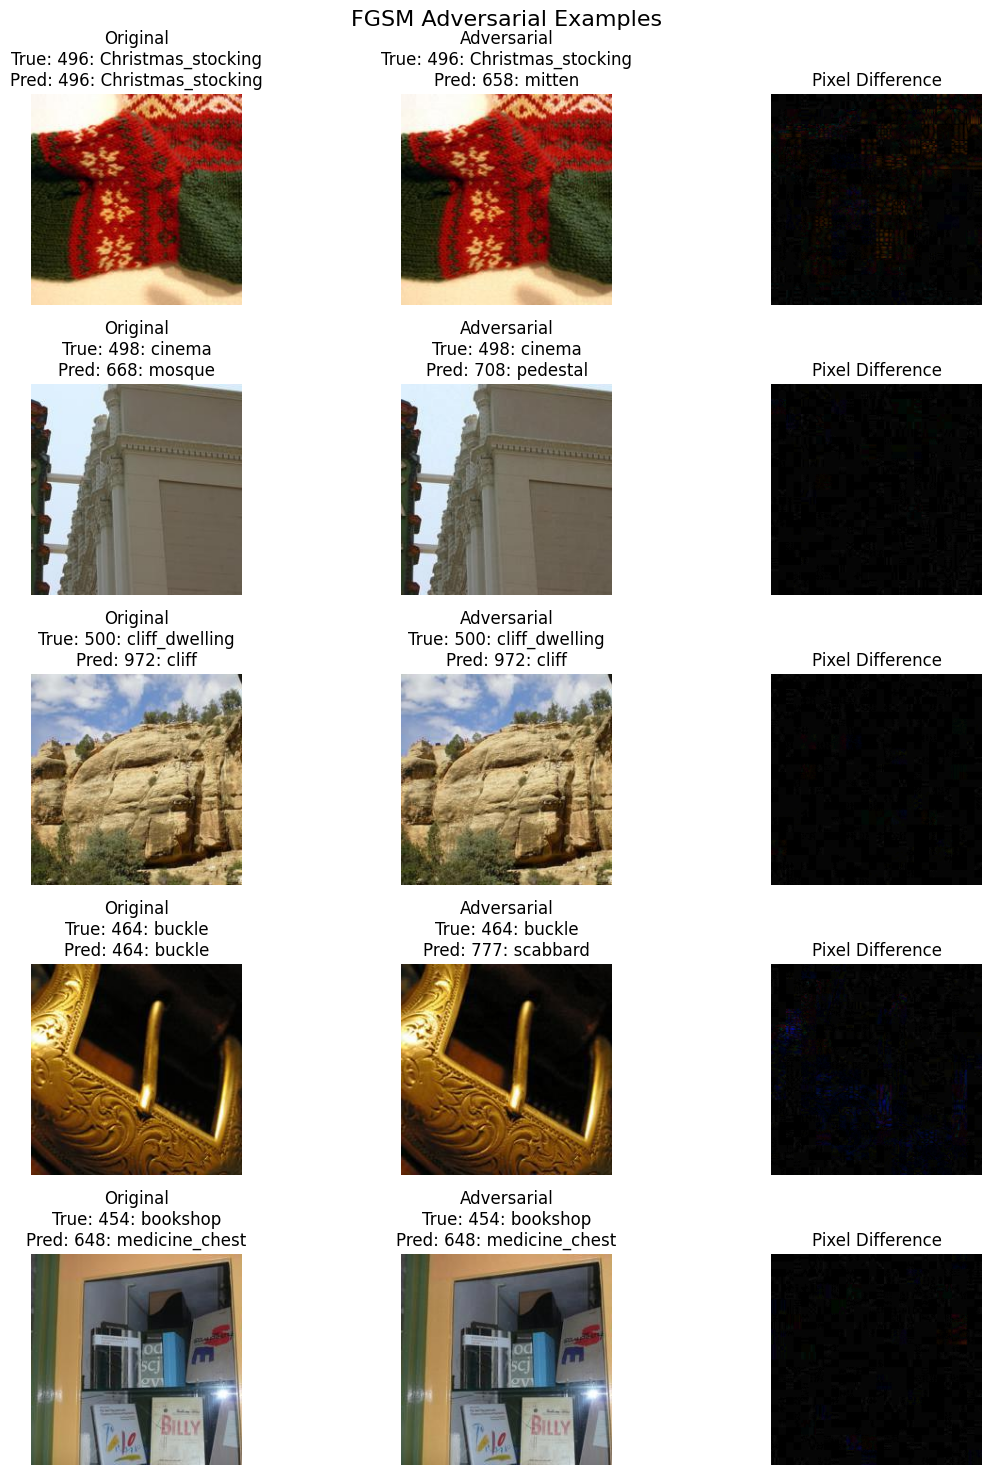

In [30]:
show_adversarial_examples(dataset, inv_normalize, num_samples=5, attack_name="FGSM", attack_folder="AdversarialTestSet1")

### Task 3: Improved Attacks

In [ ]:
# PGD Attack is a type of adversarial attack that iteratively perturbs the input image using the gradient of the loss function.
# It is a stronger attack than FGSM and is often used to evaluate the robustness of models.
def pgd_attack(model, images, labels, epsilon, alpha, iters):
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    ori_images = images.clone().detach()

    for i in range(iters):
        images.requires_grad = True
        outputs = model(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()
        grad = images.grad.data

        adv_images = images + alpha * grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-epsilon, max=epsilon)
        images = ori_images + eta
        images = images.detach()

    return images

In [32]:
adv_output_dir_pgd = "./AdversarialTestSet2"
os.makedirs(adv_output_dir_pgd, exist_ok=True)

In [ ]:
top1_pgd, top5_pgd, total_pgd = 0, 0, 0
# Hyperparameters for PGD
epsilon = 0.02
alpha = 0.1
iters = 5

In [ ]:
max_deltas = []
# Evaluate the model on PGD adversarial examples
for i, (images, targets) in enumerate(tqdm(dataloader)):
    images = images.to(device)
    imagenet_targets = torch.tensor([custom_class_to_imagenet_idx[int(t)] for t in targets]).to(device)

    # Apply PGD
    adv_images = pgd_attack(model, images, imagenet_targets, epsilon, alpha, iters)

    # Save adversarial images
    for j in range(images.size(0)):
        orig_tensor = images[j].cpu()
        adv_tensor = adv_images[j].cpu()

        satisfies_constraint, max_delta = verify_linf_constraint(orig_tensor, adv_tensor, epsilon)
        max_deltas.append(max_delta)

        unnorm_img = inv_normalize(adv_images[j].cpu()).clamp(0, 1).detach().numpy()
        unnorm_img = np.transpose(unnorm_img, (1, 2, 0))
        unnorm_img = np.clip(unnorm_img * 255, 0, 255).astype(np.uint8)

        img_pil = Image.fromarray(unnorm_img)
        label_folder = list(dataset.class_to_idx.keys())[targets[j].item()]
        fname = dataset.imgs[i * dataloader.batch_size + j][0].split("/")[-1]
        save_dir = os.path.join(adv_output_dir_pgd, label_folder)
        os.makedirs(save_dir, exist_ok=True)
        img_pil.save(os.path.join(save_dir, fname))

    # Evaluate
    outputs_adv = model(adv_images)
    _, top5_preds = outputs_adv.topk(5, dim=1)

    top1_pgd += (top5_preds[:, 0] == imagenet_targets).sum().item()
    top5_pgd += sum([imagenet_targets[b] in top5_preds[b] for b in range(len(imagenet_targets))])
    total_pgd += len(targets)

100%|██████████| 16/16 [00:14<00:00,  1.14it/s]


In [35]:
print(f"Max delta (epsilon) across dataset: {max(max_deltas):.6f}")

Max delta (epsilon) across dataset: 0.020000


In [36]:
print("\n--- PGD Attack Results ---")
print(f"Top-1 Accuracy after PGD attack: {top1_pgd / total_pgd * 100:.2f}%")
print(f"Top-5 Accuracy after PGD attack: {top5_pgd / total_pgd * 100:.2f}%")


--- PGD Attack Results ---
Top-1 Accuracy after PGD attack: 1.20%
Top-5 Accuracy after PGD attack: 34.20%


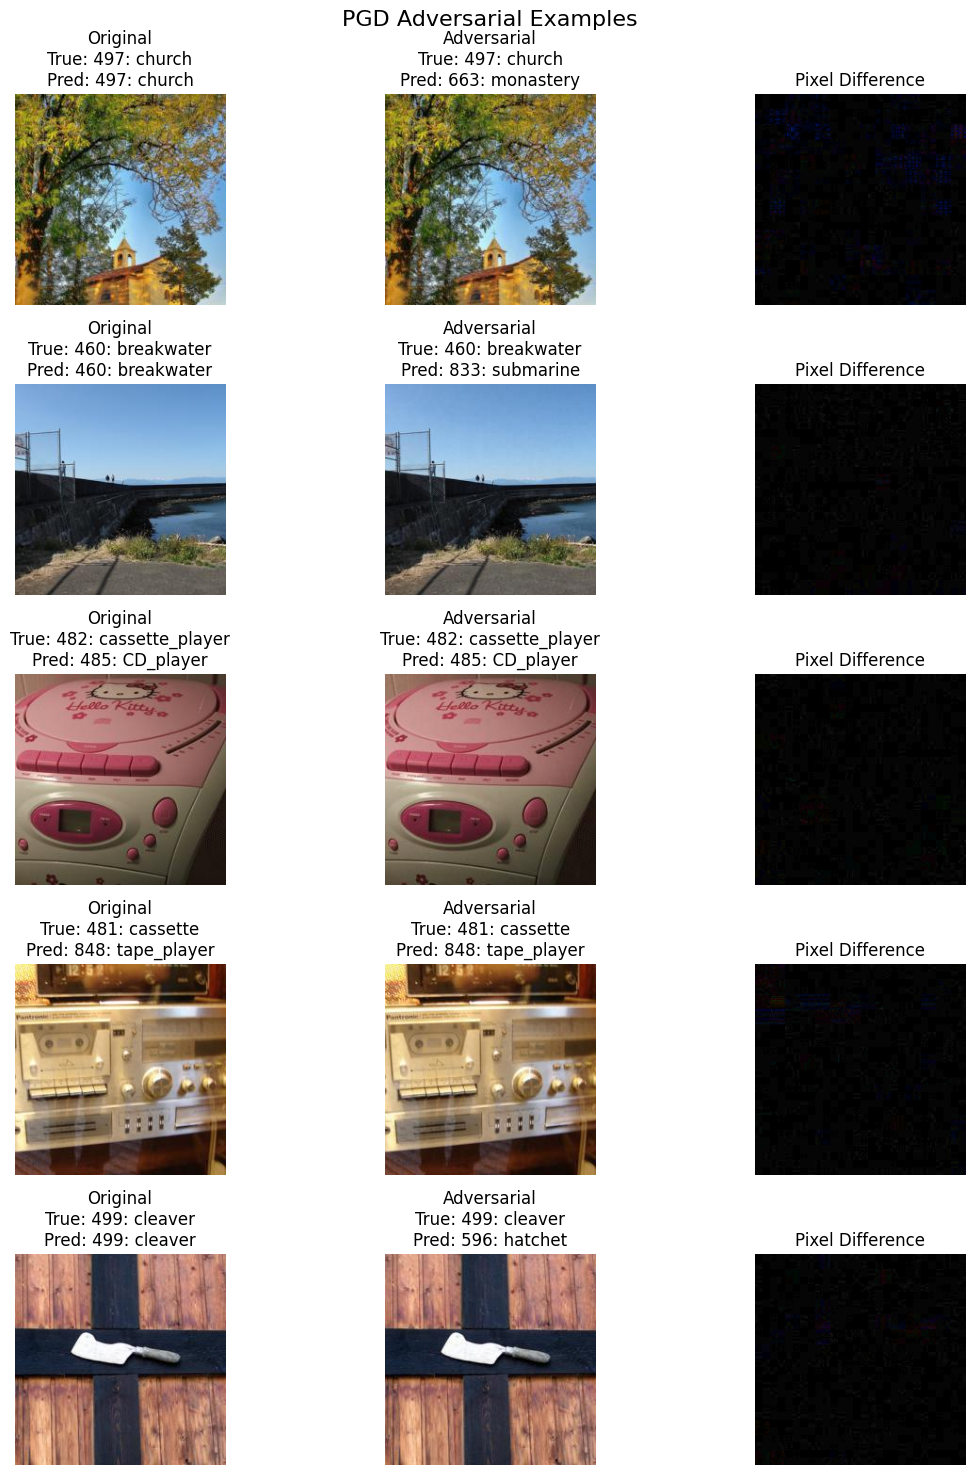

In [37]:
show_adversarial_examples(dataset, inv_normalize, num_samples=5, attack_name="PGD", attack_folder="AdversarialTestSet2")

### Task 4 : Targeted Patch Attack

In [ ]:
# Targeted Patch Attack using PGD on a patch of the image
# This attack modifies a small patch of the image to mislead the model into predicting a specific target class.
def targeted_patch_attack(model, images, true_labels, target_labels, epsilon, alpha, iters, patch_size=(32, 32)):
    images = images.clone().detach().to(device)
    target_labels = target_labels.to(device)
    B, C, H, W = images.shape
    ph, pw = patch_size

    # Initialize adversarial images
    adv_images = images.clone().detach()

    # Pick random patch positions
    x_start = torch.randint(0, W - pw, (B,))
    y_start = torch.randint(0, H - ph, (B,))

    # Apply PGD attack on the patch for the specified number of iterations
    for i in range(iters):
        adv_images.requires_grad = True
        outputs = model(adv_images)
        loss = torch.nn.functional.cross_entropy(outputs, target_labels)
        model.zero_grad()
        loss.backward()

        # Compute sign of gradient
        grad = adv_images.grad.sign()

        with torch.no_grad():
            for b in range(B):
                ys, xs = y_start[b], x_start[b]
                adv_images[b, :, ys:ys+ph, xs:xs+pw] += -alpha * grad[b, :, ys:ys+ph, xs:xs+pw]

    return adv_images.detach()

In [39]:
adv_output_dir_patch = "./AdversarialTestSet3"
os.makedirs(adv_output_dir_patch, exist_ok=True)

In [ ]:
top1_patch, top5_patch, total_patch = 0, 0, 0

# Hyperparameters for targeted patch attack
patch_size = (32, 32)
epsilon = 0.5
alpha = 0.1
iters = 20

In [ ]:
max_deltas = []
# Evaluate the model on targeted patch attack
for i, (images, targets) in enumerate(tqdm(dataloader)):
    images = images.to(device)
    true_labels = torch.tensor([custom_class_to_imagenet_idx[int(t)] for t in targets]).to(device)

    # Pick random target class which is not true label
    random_offsets = torch.randint(1, 1000, size=true_labels.shape).to(device)
    target_labels = (true_labels + random_offsets) % 1000

    # Run targeted patch attack
    adv_images = targeted_patch_attack(
        model=model,
        images=images,
        true_labels=true_labels,
        target_labels=target_labels,
        epsilon=epsilon,
        alpha=alpha,
        iters=iters,
        patch_size=patch_size
    )

    # Save images
    for j in range(images.size(0)):
        orig_tensor = images[j].cpu()
        adv_tensor = adv_images[j].cpu()

        satisfies_constraint, max_delta = verify_linf_constraint(orig_tensor, adv_tensor, epsilon)
        max_deltas.append(max_delta)

        img_tensor = inv_normalize(adv_images[j].cpu()).clamp(0, 1).numpy()
        img_tensor = np.transpose(img_tensor, (1, 2, 0))
        img_uint8 = (img_tensor * 255).astype(np.uint8)

        img_pil = Image.fromarray(img_uint8)
        label_folder = list(dataset.class_to_idx.keys())[targets[j].item()]
        fname = dataset.imgs[i * dataloader.batch_size + j][0].split("/")[-1]
        save_dir = os.path.join(adv_output_dir_patch, label_folder)
        os.makedirs(save_dir, exist_ok=True)
        img_pil.save(os.path.join(save_dir, fname))

    # Evaluate
    outputs_adv = model(adv_images)
    _, top5_preds = outputs_adv.topk(5, dim=1)

    top1_patch += (top5_preds[:, 0] == true_labels).sum().item()
    top5_patch += sum([true_labels[b] in top5_preds[b] for b in range(len(true_labels))])
    total_patch += len(targets)

100%|██████████| 16/16 [00:48<00:00,  3.04s/it]


In [50]:
print(f"Max delta (epsilon) across dataset: {max(max_deltas):.6f}")

Max delta (epsilon) across dataset: 0.500000


In [55]:
print("\n--- Targeted Patch Attack Results ---")
print(f"Top-1 Accuracy after patch attack: {top1_patch / total_patch * 100:.2f}%")
print(f"Top-5 Accuracy after patch attack: {top5_patch / total_patch * 100:.2f}%")


--- Targeted Patch Attack Results ---
Top-1 Accuracy after patch attack: 35.40%
Top-5 Accuracy after patch attack: 68.40%


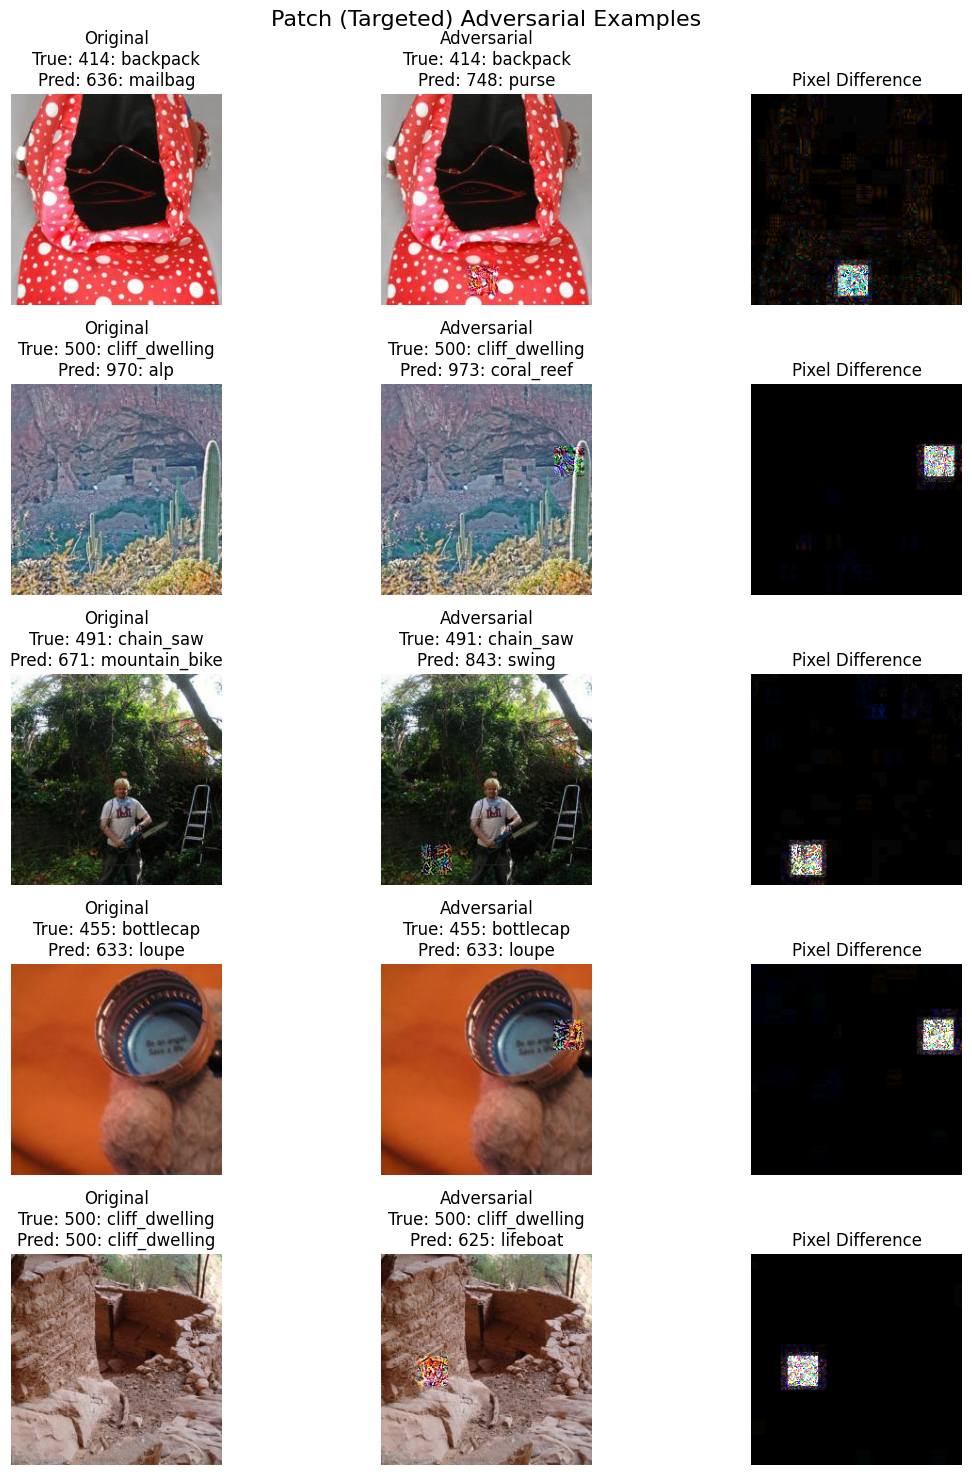

In [52]:
show_adversarial_examples(dataset, inv_normalize, num_samples=5, attack_name="Patch (Targeted)", attack_folder="AdversarialTestSet3")

In [ ]:
# Function to plot accuracies across all attacks
def plot_accuracy_comparison():
    labels = ["Original", "FGSM", "PGD", "Patch (Targeted)"]
    resnet_top1 = [top1_correct / total * 100, top1_adv / total_adv * 100, top1_pgd / total_pgd * 100, top1_patch / total_patch * 100]
    resnet_top5 = [top5_correct / total * 100, top5_adv / total_adv * 100, top5_pgd / total_pgd * 100, top5_patch / total_patch * 100]

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    bars1 = axs[0].bar(labels, resnet_top1, color=['skyblue', 'salmon', 'gray', 'gold'])
    axs[0].set_ylim(0, 100)
    axs[0].set_ylabel("Top-1 Accuracy (%)")
    axs[0].set_title("ResNet-34 Top-1 Accuracy")
    for bar, val in zip(bars1, resnet_top1):
        axs[0].text(bar.get_x() + bar.get_width() / 2, val + 1, f"{val:.1f}%", ha='center', va='bottom')

    bars2 = axs[1].bar(labels, resnet_top5, color=['skyblue', 'salmon', 'gray', 'gold'])
    axs[1].set_ylim(0, 100)
    axs[1].set_ylabel("Top-5 Accuracy (%)")
    axs[1].set_title("ResNet-34 Top-5 Accuracy")
    for bar, val in zip(bars2, resnet_top5):
        axs[1].text(bar.get_x() + bar.get_width() / 2, val + 1, f"{val:.1f}%", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

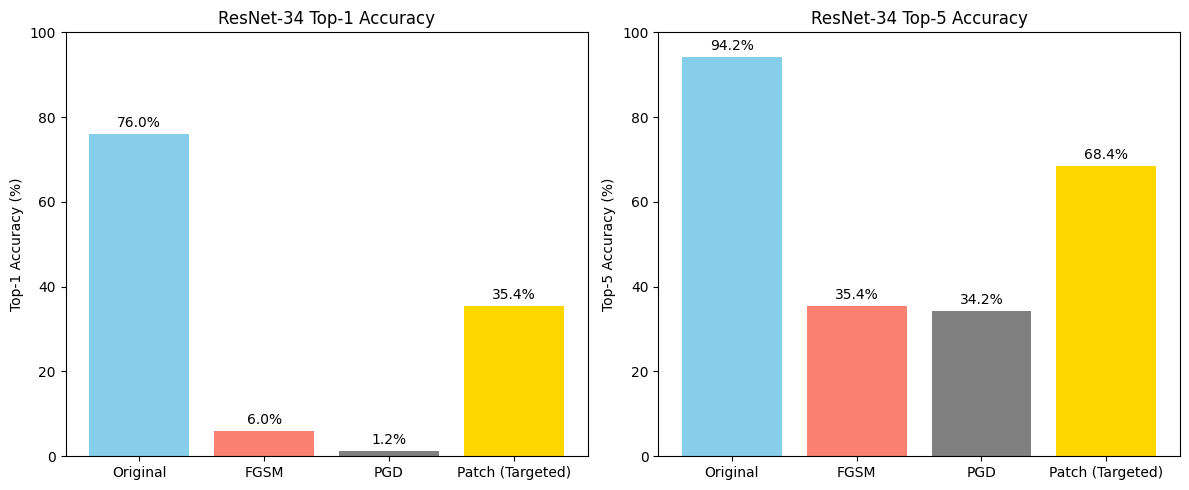

In [57]:
plot_accuracy_comparison()

### Task 5: Transferring Attacks

In [ ]:
# Testing attacks against other models
model_dict = {
    "DenseNet-121": models.densenet121(weights="IMAGENET1K_V1"), # DenseNet
    "MobileNetV3": models.mobilenet_v3_large(weights="IMAGENET1K_V1"), # MobileNetV3
    "EfficientNet-B0": models.efficientnet_b0(weights="IMAGENET1K_V1") # EfficientNet
}

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 203MB/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 162MB/s]
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 184MB/s]


In [59]:
for model_name in model_dict:
    model_dict[model_name] = model_dict[model_name].to(device)
    model_dict[model_name].eval()

In [ ]:
# Utility function to evaluate model on an adversarial image folder and then calculate accuracy
def evaluate_on_folder(model, folder_path):
    transfer_dataset = datasets.ImageFolder(root=folder_path, transform=plain_transforms)
    loader = DataLoader(transfer_dataset, batch_size=32, shuffle=False)

    top1, top5, total = 0, 0, 0
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            targets = torch.tensor([custom_class_to_imagenet_idx[int(t)] for t in targets]).to(device)
            outputs = model(images)
            _, top5_preds = outputs.topk(5, dim=1)

            top1 += (top5_preds[:, 0] == targets).sum().item()
            top5 += sum([targets[i] in top5_preds[i] for i in range(len(targets))])
            total += len(targets)

    return top1 / total * 100, top5 / total * 100

In [ ]:
all_results = {}

# Evaluate each model on the original and adversarial datasets
for model_name, model in model_dict.items():
    print(f"\n{model_name} Results:")
    results = {}
    baseline_top1, baseline_top5 = None, None

    for name, path in zip(
        ["Original", "FGSM", "PGD", "Patch (Targeted)"],
        [dataset_path, "AdversarialTestSet1", "AdversarialTestSet2", "AdversarialTestSet3"]
    ):
        top1, top5 = evaluate_on_folder(model, path)

        if name == "Original":
            baseline_top1, baseline_top5 = top1, top5

        drop1 = baseline_top1 - top1
        drop5 = baseline_top5 - top5

        results[name] = {
            "top1": top1,
            "top5": top5,
            "drop1": drop1,
            "drop5": drop5
        }

        print(f"{name} Dataset → Top-1: {top1:.2f}% (↓{drop1:.1f}%) | Top-5: {top5:.2f}% (↓{drop5:.1f}%)")

    all_results[model_name] = results


DenseNet-121 Results:
Original Dataset → Top-1: 74.80% (↓0.0%) | Top-5: 93.60% (↓0.0%)
FGSM Dataset → Top-1: 70.80% (↓4.0%) | Top-5: 92.20% (↓1.4%)
PGD Dataset → Top-1: 72.20% (↓2.6%) | Top-5: 92.20% (↓1.4%)
Patch (Targeted) Dataset → Top-1: 66.40% (↓8.4%) | Top-5: 87.60% (↓6.0%)

MobileNetV3 Results:
Original Dataset → Top-1: 83.80% (↓0.0%) | Top-5: 97.00% (↓0.0%)
FGSM Dataset → Top-1: 79.40% (↓4.4%) | Top-5: 96.40% (↓0.6%)
PGD Dataset → Top-1: 80.80% (↓3.0%) | Top-5: 96.40% (↓0.6%)
Patch (Targeted) Dataset → Top-1: 70.60% (↓13.2%) | Top-5: 91.60% (↓5.4%)

EfficientNet-B0 Results:
Original Dataset → Top-1: 83.00% (↓0.0%) | Top-5: 96.80% (↓0.0%)
FGSM Dataset → Top-1: 79.40% (↓3.6%) | Top-5: 96.40% (↓0.4%)
PGD Dataset → Top-1: 79.80% (↓3.2%) | Top-5: 96.40% (↓0.4%)
Patch (Targeted) Dataset → Top-1: 75.20% (↓7.8%) | Top-5: 93.80% (↓3.0%)


In [ ]:
# Plotting the metrics for each model
def plot_transfer_model_results(all_results):
    for model_name, result_dict in all_results.items():
        labels = list(result_dict.keys())
        top1_vals = [result_dict[label]["top1"] for label in labels]
        top5_vals = [result_dict[label]["top5"] for label in labels]

        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        bars1 = axs[0].bar(labels, top1_vals, color='mediumseagreen')
        axs[0].set_title(f"{model_name} Top-1 Accuracy")
        axs[0].set_ylabel("Accuracy (%)")
        axs[0].set_ylim(0, 100)
        for bar, val in zip(bars1, top1_vals):
            axs[0].text(bar.get_x() + bar.get_width() / 2, val + 1, f"{val:.1f}%", ha='center')

        bars2 = axs[1].bar(labels, top5_vals, color='cornflowerblue')
        axs[1].set_title(f"{model_name} Top-5 Accuracy")
        axs[1].set_ylabel("Accuracy (%)")
        axs[1].set_ylim(0, 100)
        for bar, val in zip(bars2, top5_vals):
            axs[1].text(bar.get_x() + bar.get_width() / 2, val + 1, f"{val:.1f}%", ha='center')

        plt.suptitle(f"{model_name} Accuracy Across Attacks")
        plt.tight_layout()
        plt.show()

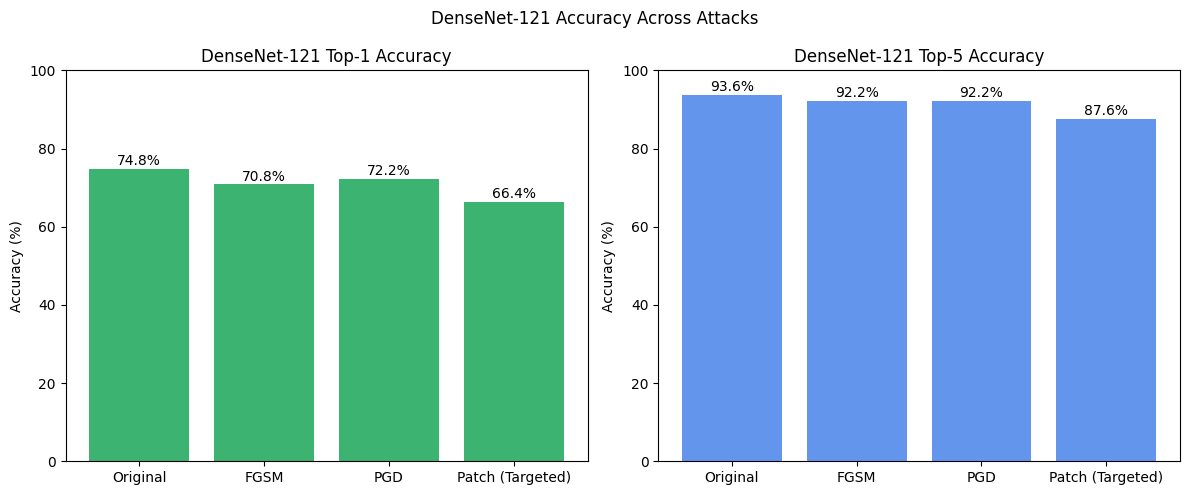

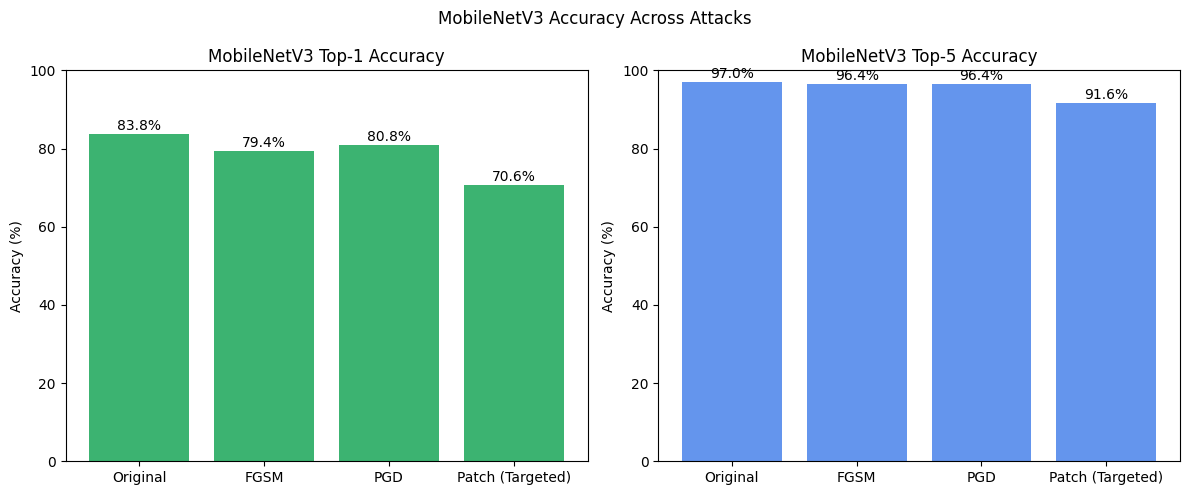

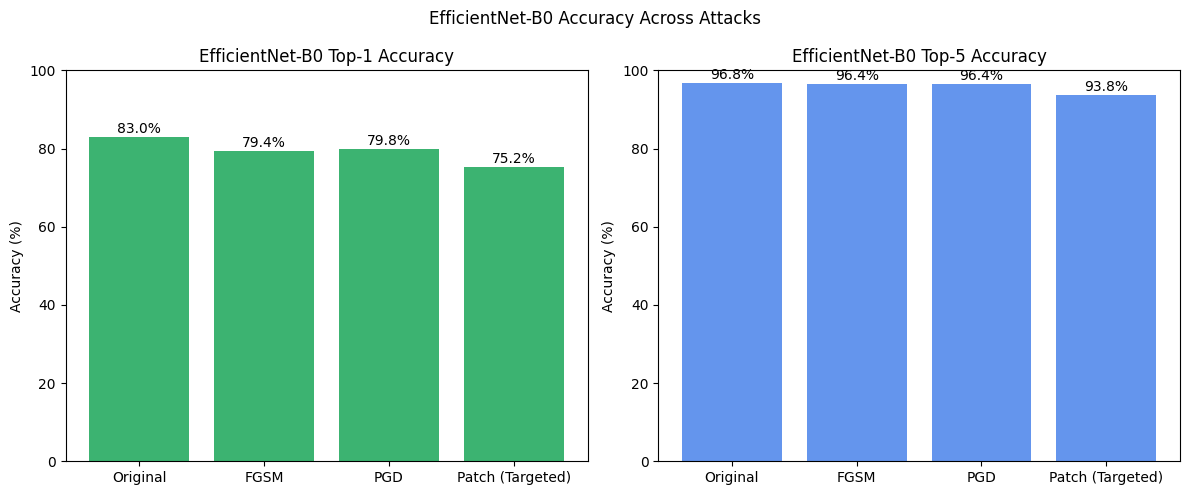

In [63]:
plot_transfer_model_results(all_results)

### Transferability Analysis

Our evaluation shows that adversarial examples generated using FGSM, PGD, and targeted patch attacks on ResNet-34 are highly effective against the source model, but their transferability to other architectures is limited and varies by model and attack type.

- **FGSM and PGD attacks** reduced ResNet-34's Top-1 accuracy by **70% and 75%** respectively, but had a **modest impact on other models**, typically causing only **3–5% drops** in Top-1 accuracy for DenseNet-121, MobileNetV3, and EfficientNet-B0.
- **Targeted patch attacks** were less effective on ResNet-34 than PGD but **transferred better** to other models — causing **up to 13.2% Top-1 drop** in MobileNetV3 and **8.4% in DenseNet-121**.
- **MobileNetV3 and EfficientNet-B0** demonstrated greater robustness overall, especially in **Top-5 accuracy**, where drops rarely exceeded **0.6%** under FGSM and PGD.
- **DenseNet-121**, despite a similar baseline to ResNet-34, showed slightly higher vulnerability to patch attacks.

#### Lessons Learned:
- Adversarial attacks crafted for one model do not always transfer well — especially for gradient-based methods like PGD and FGSM.
- **Patch-based attacks**, even when localized to a small 32×32 region, can have **greater transferability** than expected — likely due to their ability to exploit more general spatial biases.
- **Model architecture and inductive biases** (e.g., MobileNet's depthwise separable convolutions or EfficientNet's compound scaling) may influence vulnerability, particularly under transfer settings.

#### Potential Mitigations:
- **Adversarial training** across diverse architectures and attacks remains the most effective defense against both white-box and black-box attacks.
- **Preprocessing defenses**, such as random resizing, cropping, or JPEG compression, could help disrupt adversarial patterns during inference.
- **Ensemble-based models** can potentially mask model-specific weaknesses, reducing overall transferability impact.

These findings highlight that even high-performing models can remain susceptible to adversarial attacks — especially patch-based ones — and emphasize the importance of robust evaluation beyond clean test accuracy.